In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd

In [6]:
from birds_utils import DataGenerator

dataset_folder_train = './dataset/train/'
dataset_folder_val = './dataset/val/'
dgen_train = DataGenerator(dataset_folder_train, batch_size=128)
dgen_val = DataGenerator(dataset_folder_val, batch_size=128)

{'amegfi': 0, 'aldfly': 1, 'amecro': 2}
{'amegfi': 0, 'aldfly': 1, 'amecro': 2}


In [7]:
len(dgen_val)/len(dgen_train)

0.3076923076923077

In [8]:
for x, c in dgen_train:
    print(x.shape, c.shape)
    break

(128, 110250, 1) (128, 3)


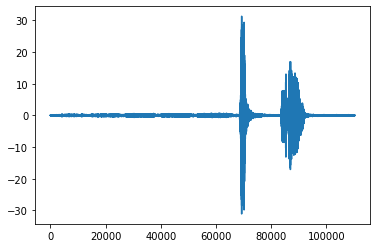

In [9]:
plt.plot(x[0,:,0])
ipd.Audio(x[0,:,0], rate=22050)

In [10]:
len(dgen_train), len(dgen_val)

(299, 92)

In [11]:
# del X, y

In [12]:
def get_fourier_weights(window_size):
    frec = np.linspace(-window_size//2, window_size//2-1, window_size)
    time = np.linspace(0, window_size-1, window_size)
    hanning_window = np.hanning(window_size)

    filters_cos = []
    filters_sin = []
    for i in range(window_size//2):
        filters_cos.append(np.cos(2*np.pi*frec[i]*time/window_size))
        filters_sin.append(np.sin(2*np.pi*frec[i]*time/window_size))
    filters_cos = np.array(filters_cos)[::-1]*hanning_window
    filters_sin = np.array(filters_sin)[::-1]*hanning_window
    return filters_cos, filters_sin

def set_cnn_weights(model, filters_cos, filters_sin, cos_layer='cos', sin_layer='sin'):
    weights_cos = model.get_layer(cos_layer).get_weights()
    weights_sin = model.get_layer(sin_layer).get_weights()
    weights_cos[0] = np.array(filters_cos).T.reshape(kernel_size, 1, filters)
    weights_sin[0] = np.array(filters_sin).T.reshape(kernel_size, 1, filters)
    model.get_layer(cos_layer).set_weights(weights_cos)
    model.get_layer(sin_layer).set_weights(weights_sin)

In [13]:
from tensorflow.keras.layers import Dense, Conv1D, Input, MaxPool1D, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [14]:
#model = Sequential()
window_size = 1024
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2
inp = Input(shape=(None,1))
cos_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'cos')(inp)
sin_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'sin')(inp)
fourier_out = K.log(K.square(cos_out) + K.square(sin_out))
# fourier_out = Activation('relu')(cos_out) + Activation('relu')(sin_out)
gap_out = GlobalAveragePooling1D()(fourier_out)
out = Dense(3, activation='softmax')(gap_out)

#  model = Model(inp, [fourier_out, out])
model = Model(inp, out)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
cos (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
sin (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square (TensorFlowO [(None, None, 512)]  0           cos[0][0]                        
______________________________________________________________________________________________

In [15]:
filters_cos, filters_sin = get_fourier_weights(window_size)
set_cnn_weights(model, filters_cos, filters_sin)

In [16]:
# model.get_layer('cos').trainable = False
# model.get_layer('sin').trainable = False

In [17]:
cbs = [
    callbacks.ModelCheckpoint('weights_2048.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True),
    # callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-5)
] 


In [18]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dgen_train, epochs=5, validation_data=dgen_val, callbacks=cbs)

Epoch 1/200
299/299 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.8151
Epoch 00001: val_accuracy improved from -inf to 0.85003, saving model to weights_2048.hdf5
299/299 [==============================] - 917s 3s/step - loss: 0.4855 - accuracy: 0.8151 - val_loss: 0.5789 - val_accuracy: 0.8500
Epoch 2/200
299/299 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9264
Epoch 00002: val_accuracy improved from 0.85003 to 0.86029, saving model to weights_2048.hdf5
299/299 [==============================] - 913s 3s/step - loss: 0.2225 - accuracy: 0.9264 - val_loss: 0.5945 - val_accuracy: 0.8603
Epoch 3/200
299/299 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9588
Epoch 00003: val_accuracy improved from 0.86029 to 0.86047, saving model to weights_2048.hdf5
299/299 [==============================] - 917s 3s/step - loss: 0.1497 - accuracy: 0.9588 - val_loss: 0.6006 - val_accuracy: 0.8605
Epoch 4/200
299/299 [=============

KeyboardInterrupt: 

In [ ]:
# time = np.linspace(0, window_size-1, window_size)
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_cos[i])
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_sin[i])

In [ ]:
# filters_cos, filters_sin = get_fourier_weights(window_size)
# set_cnn_weights(model, filters_cos, filters_sin)

In [ ]:
model.evaluate(dgen_val)

10/92 [==>...........................] - ETA: 52s - loss: 0.5796 - accuracy: 0.8445

In [40]:
model.load_weights('weights_1024.hdf5')
model.evaluate(dgen_val)

19/19 [==============================] - 1s 38ms/step - loss: 0.6039 - accuracy: 0.7296


[0.6038753986358643, 0.7296280860900879]

In [41]:
# 0.9569892287254333 window size 512

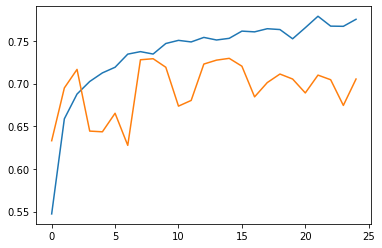

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [43]:
weights_cos = model.get_layer('cos').get_weights()[0].T.reshape(filters_cos.shape)
weights_sin = model.get_layer('sin').get_weights()[0].T.reshape(filters_sin.shape)

In [49]:
most_diff_indexes = np.argsort((weights_cos - filters_cos).var(axis=1))[::-1]

In [45]:
most_diff_indexes[:20]

array([511, 256, 254,  55, 455, 451,  59, 321, 509,   1, 189,  51, 502,
         8, 459, 102, 408,  65,   6, 170])

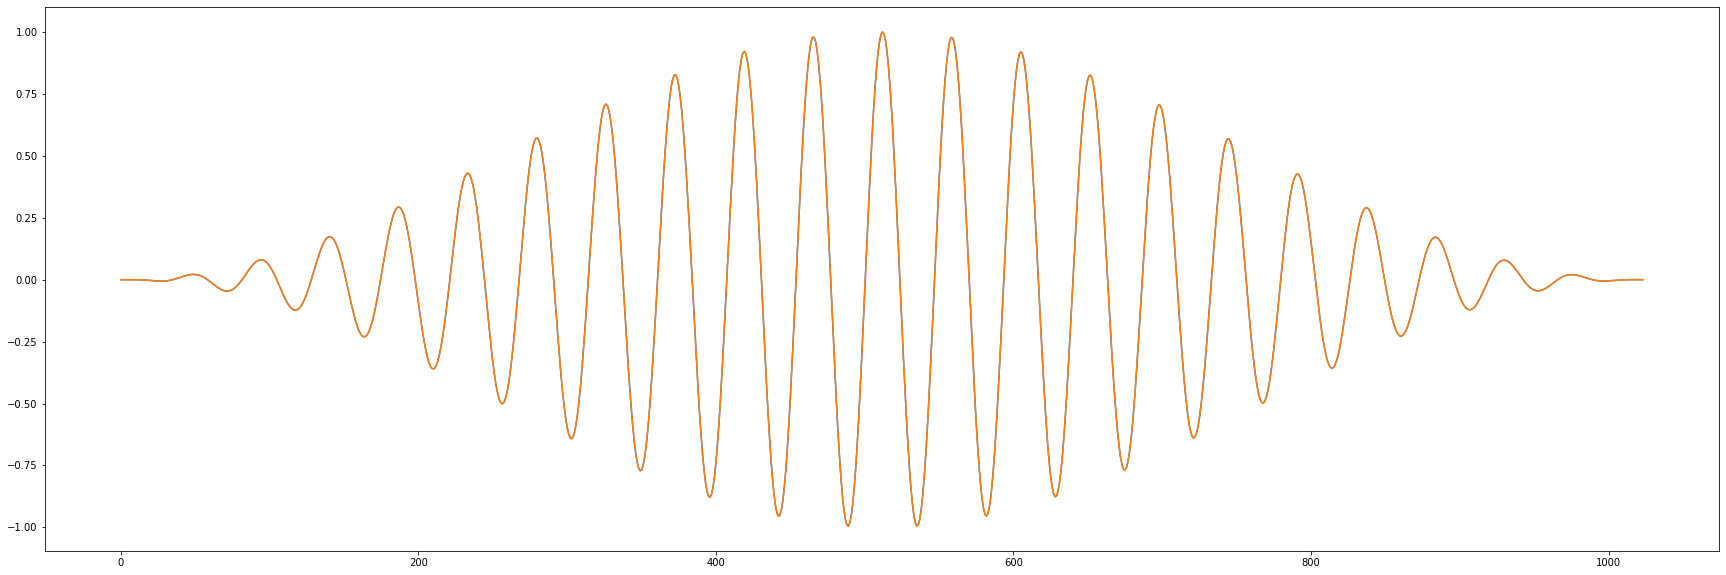

In [46]:
idx = 21
plt.figure(figsize=(30,10))
plt.plot(weights_cos[idx])
plt.plot(filters_cos[idx])

In [48]:
# x, sr, duration = get_train_clip(train[train['ebird_code']=='ameavo'].iloc[0])
# print(duration)